In [46]:
import numpy as np
import itertools
import pandas as pd
import os 
import jax.numpy as jnp

# print(jnp.logspace(-6, -1, 15)[:])

devs = np.logspace(-6, -1, 15)[:]

print([dev for dev in devs])

# print(os.listdir("../../results/Gaussian_MAMS_Paper"))
integrator_types = ['velocity_verlet'
                    # , 'mclachlan', 
                    # 'omelyan'
                    ]

samplers = [[
    
    # f"adjusted_microcanonical_{integrator_type}", 
    # f"unadjusted_microcanonical__{integrator_type}",
    f"underdamped_langevin_{dev}",
    # f"adjusted_hmc_{integrator_type}",
    # f"adjusted_malt",
    

                
                ] for dev in devs]

samplers = [
    x
    for xs in samplers
    for x in xs
]

print(samplers)

# grid_samplers = [
#     [
#         f"grid_search_unadjusted_lmc_{integrator_type}",
    
# #     f"grid_search_adjusted_microcanonical_{integrator_type}",
# #     f"grid_search_unadjusted_microcanonical_{integrator_type}",
#      ] for integrator_type in integrator_types]


# Ds = np.concatenate([np.arange(2,10), np.ceil(np.logspace(2,4, 5)).astype(int)])[:]
# models = [f"Rosenbrock_{D*2}" for D in Ds]


models = [f"ICG"]



df_tuned = pd.concat([pd.read_csv(f"../../results/Gaussian_MAMS_Paper/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, models)], ignore_index=True)
df_tuned_brownian = pd.concat([pd.read_csv(f"../../results/vector_brownian_motion_unknown_scales_missing_middle_observations/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, ["vector_brownian_motion_unknown_scales_missing_middle_observations"])], ignore_index=True)
df_tuned_rosenbrock = pd.concat([pd.read_csv(f"../../results/rosenbrock_36d/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, ["rosenbrock_36d"])], ignore_index=True)
# df_tuned = pd.concat([pd.read_csv(f"results/tuned/Rosenbrock/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, models)], ignore_index=True)
df_tuned_german_credit = pd.concat([pd.read_csv(f"../../results/vector_german_credit_numeric_sparse_logistic_regression/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, ["vector_german_credit_numeric_sparse_logistic_regression"])], ignore_index=True)

df = df_tuned_rosenbrock

# df_grid = pd.concat([pd.read_csv(f"results/grid_search/Gaussian/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, models)], ignore_index=True)

# df["dim"] = df["Model"].str.extract(r"(\d+)").astype(int)
df['dev'] = df['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df = df[df["max"] == False]
df = df[(df["statistic"] == 'square')]
df['Integrator'] = df['Sampler'].apply(lambda x: x.split('_')[-1])
# df['Sampler'] = df['Sampler'].apply(lambda x: x.split('_')[0]+x.split('_')[1]+x.split('_')[2] if x[0]=='g' else x.split('_')[0])
# df['Sampler'] = df['Sampler'].apply({
#     'unadjusted_microcanonical__velocity_verlet': 'unadjusted_microcanonical_velocity_verlet',
#     'adjusted_microcanonical_velocity_verlet': 'adjusted_microcanonical_velocity_verlet',
#     'underdamped_langevin_velocity_verlet': 'underdamped_langevin_velocity_verlet',
#     'adjusted_hmc_velocity_verlet': 'adjusted_hmc_velocity_verlet',
#     'adjusted_malt': 'adjusted_malt',
# }.get)
df['ESS'] = 100/df["num_grads_to_low_error"]
df[df['Integrator']=='velocity_verlet']
# df=df[df["Sampler"]=='adjusted_microcanonical_velocity_verlet']

df

[1e-06, 2.2758459260747865e-06, 5.179474679231212e-06, 1.1787686347935867e-05, 2.6826957952797274e-05, 6.105402296585326e-05, 0.00013894954943731373, 0.00031622776601683794, 0.0007196856730011522, 0.0016378937069540646, 0.0037275937203149418, 0.008483428982440725, 0.019306977288832496, 0.04393970560760795, 0.1]
['underdamped_langevin_1e-06', 'underdamped_langevin_2.2758459260747865e-06', 'underdamped_langevin_5.179474679231212e-06', 'underdamped_langevin_1.1787686347935867e-05', 'underdamped_langevin_2.6826957952797274e-05', 'underdamped_langevin_6.105402296585326e-05', 'underdamped_langevin_0.00013894954943731373', 'underdamped_langevin_0.00031622776601683794', 'underdamped_langevin_0.0007196856730011522', 'underdamped_langevin_0.0016378937069540646', 'underdamped_langevin_0.0037275937203149418', 'underdamped_langevin_0.008483428982440725', 'underdamped_langevin_0.019306977288832496', 'underdamped_langevin_0.04393970560760795', 'underdamped_langevin_0.1']


,Unnamed: 0,Sampler,Model,num_grads_to_low_error,ess_corr,max,statistic,num_tuning_grads,L,step_size,dev,Integrator,ESS
5,5,underdamped_langevin_1e-06,rosenbrock_36d,49676.0,NaN,False,square,115556.0,2.230642,0.012922,0.000001,1e-06,0.002013
11,5,underdamped_langevin_2.2758459260747865e-06,rosenbrock_36d,39413.0,NaN,False,square,115556.0,2.258828,0.014736,0.000002,2.2758459260747865e-06,0.002537
17,5,underdamped_langevin_5.179474679231212e-06,rosenbrock_36d,35860.0,NaN,False,square,115556.0,2.331961,0.016847,0.000005,5.179474679231212e-06,0.002789
23,5,underdamped_langevin_1.1787686347935867e-05,rosenbrock_36d,29304.0,NaN,False,square,115556.0,2.334006,0.019133,0.000012,1.1787686347935867e-05,0.003413
29,5,underdamped_langevin_2.6826957952797274e-05,rosenbrock_36d,25871.0,NaN,False,square,115556.0,2.353966,0.021970,0.000027,2.6826957952797274e-05,0.003865
35,5,underdamped_langevin_6.105402296585326e-05,rosenbrock_36d,21219.0,NaN,False,square,115556.0,2.390876,0.025216,0.000061,6.105402296585326e-05,0.004713
41,5,underdamped_langevin_0.00013894954943731373,rosenbrock_36d,18545.0,NaN,False,square,115556.0,2.397187,0.028606,0.000139,0.00013894954943731373,0.005392
47,5,underdamped_langevin_0.00031622776601683794,rosenbrock_36d,16251.0,NaN,False,square,115556.0,2.403355,0.033150,0.000316,0.00031622776601683794,0.006153
53,5,underdamped_langevin_0.0007196856730011522,rosenbrock_36d,14208.0,NaN,False,square,115556.0,2.463488,0.038789,0.000720,0.0007196856730011522,0.007038
59,5,underdamped_langevin_0.0016378937069540646,rosenbrock_36d,12070.0,NaN,False,square,115556.0,2.431892,0.043375,0.001638,0.0016378937069540646,0.008285


In [33]:
# # plot num_grads_to_low_error against sampler
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.lineplot(data=df,x='dev', y='num_grads_to_low_error')
# # log x axis
# plt.xscale('log')
# # x label
# plt.xlabel('EEVPD')
# plt.ylabel('Number of Gradient Evaluations')
# plt.title('Gradient Evaluations vs Desired EEVPD: Rosenbrock')

# # horizontal line at 1142
# plt.axhline(y=8410, color='r', linestyle='--')
# plt.show()



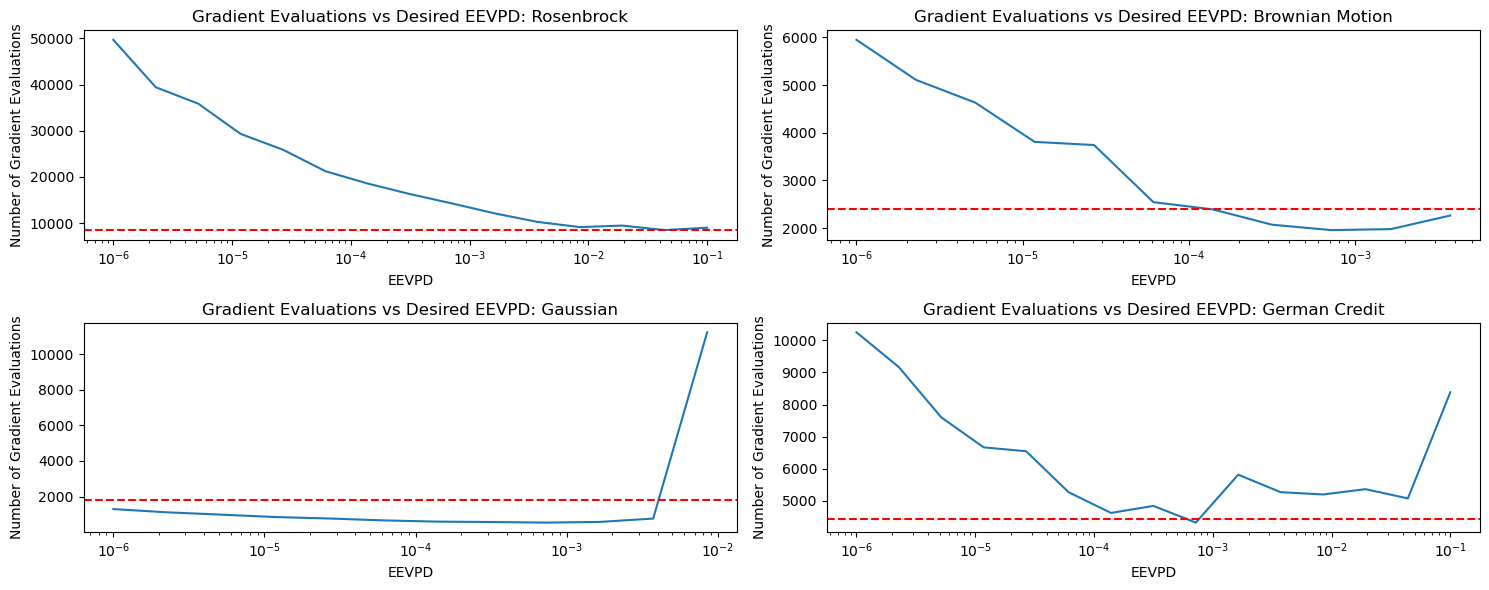

In [49]:

# Create a figure with multiple subplots for different datasets
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2 subplots (one for each dataset)
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot for Rosenbrock dataset
sns.lineplot(data=df_tuned_rosenbrock[
    (df_tuned_rosenbrock["max"] == False) & 
    (df_tuned_rosenbrock["statistic"] == 'square')
], x='dev', y='num_grads_to_low_error', ax=axes[0,0])
axes[0,0].set_xscale('log')
axes[0,0].set_xlabel('EEVPD')
axes[0,0].set_ylabel('Number of Gradient Evaluations')
axes[0,0].set_title('Gradient Evaluations vs Desired EEVPD: Rosenbrock')
axes[0,0].axhline(y=8410, color='r', linestyle='--')

# Plot for Brownian Motion dataset
# First prepare the Brownian Motion data similar to Rosenbrock
df_brownian = df_tuned_brownian.copy()
df_brownian['dev'] = df_brownian['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df_brownian = df_brownian[df_brownian["max"] == False]
df_brownian = df_brownian[(df_brownian["statistic"] == 'square')]

sns.lineplot(data=df_brownian, x='dev', y='num_grads_to_low_error', ax=axes[0,1])
axes[0,1].set_xscale('log')
axes[0,1].set_xlabel('EEVPD')
axes[0,1].set_ylabel('Number of Gradient Evaluations')
axes[0,1].set_title('Gradient Evaluations vs Desired EEVPD: Brownian Motion')
# Add a horizontal reference line if you have a benchmark value for Brownian Motion
# Find the minimum value to use as reference
axes[0,1].axhline(y=2407, color='r', linestyle='--')

df_tuned['dev'] = df_tuned['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df_tuned = df_tuned[df_tuned["max"] == False]
df_tuned = df_tuned[(df_tuned["statistic"] == 'square')]
sns.lineplot(data=df_tuned, x='dev', y='num_grads_to_low_error', ax=axes[1,0])
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel('EEVPD')
axes[1,0].set_ylabel('Number of Gradient Evaluations')
axes[1,0].set_title('Gradient Evaluations vs Desired EEVPD: Gaussian')
axes[1,0].axhline(y=1830, color='r', linestyle='--')

df_tuned_german_credit['dev'] = df_tuned_german_credit['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df_tuned_german_credit = df_tuned_german_credit[df_tuned_german_credit["max"] == False]
df_tuned_german_credit = df_tuned_german_credit[(df_tuned_german_credit["statistic"] == 'square')]
sns.lineplot(data=df_tuned_german_credit, x='dev', y='num_grads_to_low_error', ax=axes[1,1])
axes[1,1].set_xscale('log')
axes[1,1].set_xlabel('EEVPD')
axes[1,1].set_ylabel('Number of Gradient Evaluations')
axes[1,1].set_title('Gradient Evaluations vs Desired EEVPD: German Credit')
# Add a horizontal reference line if you have a benchmark value for German Credit
axes[1,1].axhline(y=4423, color='r', linestyle='--')




plt.tight_layout()
plt.show()
